# Notebook pour comprendre le Probleme Farhang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import root
import copy

Un Exemple d'état SOC (un peu déplacé vers le haut mais ca ne devrait pas avoir une grande importance pour la démo)

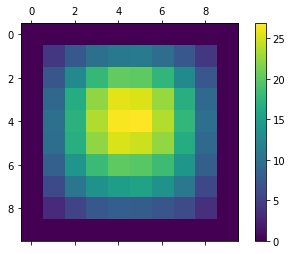

In [2]:
lat_B = np.load('/home/hlamarre/PycharmProjects/Avalanches/Saves/N10_Farhang.npz')['lat_B']
def plot_lat(lattice):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(lattice, interpolation='nearest')
    fig.colorbar(cax)
    plt.show()
plot_lat(lat_B)

Maintenant, calculons la courbure de ce lattice

In [3]:
def curvature(lattice):
    curv = np.zeros((10,10))  # curvature of the lattice initialization
    curv[1:-1, 1:-1] = lattice[1:-1, 1:-1] - 1 / 4 * (lattice[1:-1, 0:-2] + lattice[1:-1, 2:] +
                                lattice[0:-2, 1:-1] + lattice[2:, 1:-1])  # curvature computation
    return curv

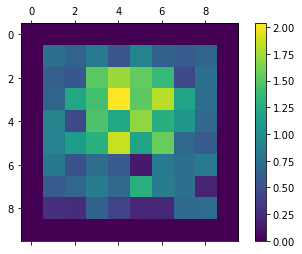

In [4]:
plot_lat(curvature(lat_B))

Le point du lattice avec la courbure la plus élevé est le point (3,4)

In [5]:
print(curvature(lat_B)[3,4])
i, j = 3, 4

2.036422317474443


Commencons par utiliser la technique d'Antoine, mais avant, nous voulons définir l'énergie totale du lattice avec le courant:
$$E = \sum_n \frac{1}{2} A_n\cdot J_n$$

In [6]:
def e_total(lattice):
    """ Returns the total energy of a specified lattice """
    return np.sum(1/2*np.multiply(lattice[1:-1, 1:-1],
                                  4*lattice[1:-1, 1:-1] - lattice[1:-1, :-2] -
                                  lattice[2:, 1:-1] - lattice[1:-1, 2:] - lattice[:-2, 1:-1]))

Ensuite, nous définissons des r aléatoires.

In [7]:
[r1, r2, r3, r4] = np.random.uniform(0, 1, size=(4, 1))
a = r1 + r2 + r3 + r4
Zc = 1
new_lat = copy.deepcopy(lat_B)
new_lat[i, j] -= 4 / 5 * Zc
new_lat[i, j - 1] += 4 / 5 * r1 /a * Zc
new_lat[i, j + 1] += 4 / 5 * r3 /a * Zc
new_lat[i - 1, j] += 4 / 5 * r4 /a* Zc
new_lat[i + 1, j] += 4 / 5 * r2 /a * Zc

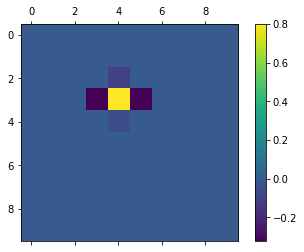

In [8]:
# La difference entre avant et apres
plot_lat(lat_B - new_lat)

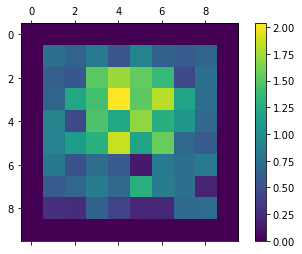

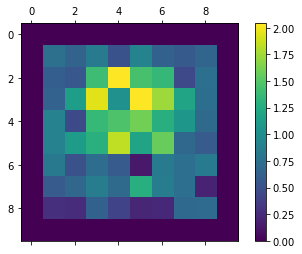

In [9]:
plot_lat(curvature(lat_B))
plot_lat(curvature(new_lat))

Si nous calculons la difference d'énergie nous trouvons que l'état nouveau est plus énergétique, c'est parce que notre Zc est trop grand

In [10]:
print(e_total(new_lat) - e_total(lat_B))

0.6098207212949092


Refaisons l'exercice avec un Zc plus approprié

In [11]:
[r1, r2, r3, r4] = np.random.uniform(0, 1, size=(4, 1))
a = r1 + r2 + r3 + r4
Zc = 0.1
new_lat = copy.deepcopy(lat_B)
new_lat[i, j] -= 4 / 5 * Zc
new_lat[i, j - 1] += 4 / 5 * r1 /a * Zc
new_lat[i, j + 1] += 4 / 5 * r3 /a * Zc
new_lat[i - 1, j] += 4 / 5 * r4 /a* Zc
new_lat[i + 1, j] += 4 / 5 * r2 /a * Zc
print(e_total(new_lat) - e_total(lat_B))

-0.15537519835925195


Maintenant dans le cadre du Farhang, nous devons définir des fonctions d'optimisations et du courant:
$$J_z|_{ij} = 4A_{ij} - A_{i+1j} - A_{i-1j} - A_{ij+1} - A_{ij-1}$$
Ainsi que
$$x = \frac{Z_{c}(r_1^2 + r_2^2 + r_3^2 - ax) - \frac{5}{32}a\theta}{\frac{5}{32}\theta + aZ_c}$$

$$\theta = r_1(-2J_{ij-1} + 3A_{ij-1}) + r_2(-2J_{i+1j} + 3A_{i+1j})+r_3(-2J_{ij+1}+3A_{ij+1}) + a(2J_{i-1j} - 3A_{i-1j})$$

In [12]:
def current(lattice, i, j):
    """ Computes the electric current J at a lattice point i,j """
    if i == 0:  # These conditions check if the point we are looking is near an edge
        a = 0
    else:
        a = lattice[i - 1, j]
    if i == 9:
        b = 0
    else:
        b = lattice[i+1, j]
    if j == 0:
        c = 0
    else:
        c = lattice[i, j-1]
    if j == 9:
        d = 0
    else:
        d = lattice[i, j+1]
    return 4*lattice[i, j] - a - b - c - d  # Computes the current using a derivative approximation
def opt_x(x, Zc, r1, r2, r3, theta):
    """ Function that defines x, the optimization parameter. Is used in root finding. """
    a = r1 + r2 + r3
    return (Zc * (r1**2 + r2**2 + r3**2 - a * x) - 5 / 32 * a * theta) / (5 / 32 * theta + a * Zc) - x

nous avons donc

In [13]:
[r1, r2, r3] = np.random.uniform(0, 1, size=(3, 1))  # Stochastic redistribution
a = r1 + r2 + r3
# Theta is used in finding x that minimizes lattice energy
theta = r1 * (-2 * current(lat_B, i, j - 1) + 3 * lat_B[i, j - 1]) + \
        r2 * (-2 * current(lat_B, i + 1, j) + 3 * lat_B[i + 1, j]) + \
        r3 * (-2 * current(lat_B, i, j + 1) + 3 * lat_B[i, j + 1]) + \
        a * (2 * current(lat_B, i - 1, j) - 3 * lat_B[i - 1, j])
Zc = 1
x = root(opt_x, 1, args=(Zc, r1, r2, r3, theta))['x'][0]
new_lat = copy.deepcopy(lat_B)
new_lat[i, j] -= 4 / 5 * Zc
new_lat[i, j - 1] += 4 / 5 * r1 / (x + a) * Zc
new_lat[i, j + 1] += 4 / 5 * r3 / (x + a) * Zc
new_lat[i - 1, j] += 4 / 5 * x / (x + a) * Zc
new_lat[i + 1, j] += 4 / 5 * r2 / (x + a) * Zc

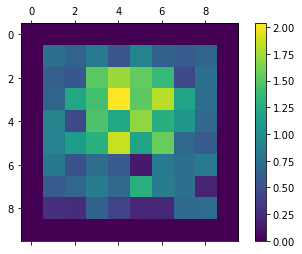

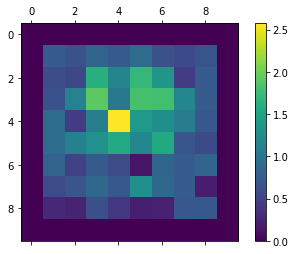

2.1372187655106245


In [14]:
plot_lat(curvature(lat_B))
plot_lat(curvature(new_lat))
print(e_total(new_lat) - e_total(lat_B))

Nous avons encore une fois le probleme que tout a l'heure. Essayons de réduire Zc

In [79]:
[r1, r2, r3] = np.random.uniform(0, 1, size=(3, 1))  # Stochastic redistribution
a = r1 + r2 + r3
# Theta is used in finding x that minimizes lattice energy
theta = r1 * (-2 * current(lat_B, i, j - 1) + 3 * lat_B[i, j - 1]) + \
        r2 * (-2 * current(lat_B, i + 1, j) + 3 * lat_B[i + 1, j]) + \
        r3 * (-2 * current(lat_B, i, j + 1) + 3 * lat_B[i, j + 1]) + \
        a * (2 * current(lat_B, i - 1, j) - 3 * lat_B[i - 1, j])
Zc = 0.01
x = root(opt_x, 1, args=(Zc, r1, r2, r3, theta))['x'][0]
new_lat = copy.deepcopy(lat_B)
new_lat[i, j] -= 4 / 5 * Zc
new_lat[i, j - 1] += 4 / 5 * r1 / (x + a) * Zc
new_lat[i, j + 1] += 4 / 5 * r3 / (x + a) * Zc
new_lat[i - 1, j] += 4 / 5 * x / (x + a) * Zc
new_lat[i + 1, j] += 4 / 5 * r2 / (x + a) * Zc
print(e_total(new_lat) - e_total(lat_B))
print(x)

0.7830067700283507
-1.8471302232745894


Ca ne fonctionne pas. En d'autre mots, peu importe a quel point nous redistribuons peu, le nouveau lattice sera toujours énergétique. Pour comprendre ce qui se passe, nous observons que x est négatif

In [16]:
x

-1.9139468063444154

Cependant, nous voudrions un x positif pour la redistribution. Observons la fonction à optimiser pour voir s'il existe d'autres solutions positives

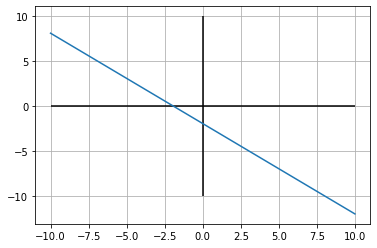

In [17]:
x_list = np.linspace(-10,10, 100)
y_list = opt_x(x_list, Zc, r1, r2, r3, theta)
plt.figure()
plt.plot(x_list, y_list)
plt.vlines(0, -10,10, color = 'black')
plt.hlines(0,-10,10, color = 'black')
plt.grid(visible = True)
plt.show()

Cette fonction n'intercepte jamais 0 pour des x positifs, essayons de voir si ceci est dépendant des r choisis

In [18]:
for k in range(10000):
    [r1, r2, r3] = np.random.uniform(0, 1, size=(3, 1))  # Stochastic redistribution
    a = r1 + r2 + r3
    # Theta is used in finding x that minimizes lattice energy
    theta = r1 * (-2 * current(lat_B, i, j - 1) + 3 * lat_B[i, j - 1]) + \
            r2 * (-2 * current(lat_B, i + 1, j) + 3 * lat_B[i + 1, j]) + \
            r3 * (-2 * current(lat_B, i, j + 1) + 3 * lat_B[i, j + 1]) + \
            a * (2 * current(lat_B, i - 1, j) - 3 * lat_B[i - 1, j])
    Zc = 0.01
    x = root(opt_x, 1, args=(Zc, r1, r2, r3, theta))['x'][0]
    if x > 0:
        print("Trouvé une solution")

Ca n'arrive jamais?

In [41]:
def new_opt_x(x, Zc, r1, r2, r3, theta):
    a = r1+r2+r3
    return 6.4*Zc * (r1**2+r2**2+r3**2-a*x)/(x+a) - theta

In [104]:
i,j  = 5,7
[r1, r2, r3] = np.random.uniform(0, 1, size=(3, 1))  # Stochastic redistribution
a = r1 + r2 + r3
Zc = 0.1
theta = r1*(-2*current(lat_B, i, j-1) - lat_B[i,j]) + r2*(-2*current(lat_B, i+1,j) - lat_B[i,j]) +\
        r3*(-2*current(lat_B, i,j+1) - lat_B[i,j]) - a*(-2*current(lat_B, i-1, j) - lat_B[i,j]) 
x = root(new_opt_x, 1, args=(Zc, r1, r2, r3, theta))['x'][0]
new_lat = copy.deepcopy(lat_B)
new_lat[i, j] -= 4 / 5 * Zc
new_lat[i, j - 1] += 4 / 5 * r1 / (x + a) * Zc
new_lat[i, j + 1] += 4 / 5 * r3 / (x + a) * Zc
new_lat[i - 1, j] += 4 / 5 * x / (x + a) * Zc
new_lat[i + 1, j] += 4 / 5 * r2 / (x + a) * Zc
print(e_total(new_lat) - e_total(lat_B))
print(x)

-0.18292296897061533
-1.1613370771908975


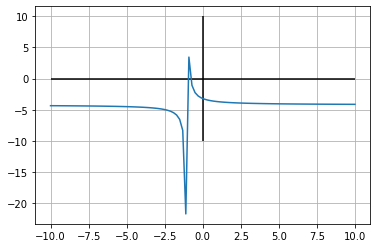

In [23]:
x_list = np.linspace(-10,10, 100)
y_list = new_opt_x(x_list, Zc, r1, r2, r3, theta)
plt.figure()
plt.plot(x_list, y_list)
plt.vlines(0, -10,10, color = 'black')
plt.hlines(0,-10,10, color = 'black')
plt.grid(visible = True)
plt.show()

In [24]:
for k in range(10000):
    [r1, r2, r3] = np.random.uniform(0, 1, size=(3, 1))  # Stochastic redistribution
    a = r1 + r2 + r3
    Zc = 0.1
    theta = r1*(-2*current(lat_B, i, j-1) - lat_B[i,j]) + r2*(-2*current(lat_B, i+1,j) - lat_B[i,j]) +\
            r3*(-2*current(lat_B, i,j+1) - lat_B[i,j]) - a*(-2*current(lat_B, i-1, j) - lat_B[i,j]) 
    x = root(new_opt_x, 1, args=(Zc, r1, r2, r3, theta))['x'][0]
    new_lat = copy.deepcopy(lat_B)
    new_lat[i, j] -= 4 / 5 * Zc
    new_lat[i, j - 1] += 4 / 5 * r1 / (x + a) * Zc
    new_lat[i, j + 1] += 4 / 5 * r3 / (x + a) * Zc
    new_lat[i - 1, j] += 4 / 5 * x / (x + a) * Zc
    new_lat[i + 1, j] += 4 / 5 * r2 / (x + a) * Zc
    if x > 0:
        print("Trouvé une solution")

In [26]:
from scipy.misc import derivative

In [28]:
derivative(new_opt_x, x, args = (Zc, r1, r2, r3, theta))

array([2.06932501])